# DMI Ocean Observations

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

1. Get API key
2. Find station id from this table https://confluence.govcloud.dk/pages/viewpage.action?pageId=30015718
3. Download data

In [2]:
api_key = "e11..." # Replace with correct API key

In [3]:
from fmskill import ModelResult, PointObservation, Connector

m1 = ModelResult("../tests/testdata/Oresund2D.dfsu", item="Surface elevation")
m1

<DfsModelResultItem> 'Oresund2D'
File: ../tests/testdata/Oresund2D.dfsu
- Item: 0: Surface elevation <Surface Elevation> (meter)

In [21]:
from fmskill.data.dmi import DMIOceanObsRepository

repo = DMIOceanObsRepository(apikey=api_key)

station_id = "30336" # Kbh havn

df = repo.get_observations(station_id=station_id, start_time=m1.start_time, end_time=m1.end_time, n=10000)
df.head()

,sealev_dvr
time,
2018-03-04 00:00:00,-0.22
2018-03-04 00:10:00,-0.23
2018-03-04 00:20:00,-0.26
2018-03-04 00:30:00,-0.27
2018-03-04 00:40:00,-0.28


In [22]:
df = df.rename(columns={'sealev_dvr': 'copenhagen_harbour'})
df.head()

,copenhagen_harbour
time,
2018-03-04 00:00:00,-0.22
2018-03-04 00:10:00,-0.23
2018-03-04 00:20:00,-0.26
2018-03-04 00:30:00,-0.27
2018-03-04 00:40:00,-0.28


In [23]:
o1 = PointObservation(df, x=350000, y=6174000)

In [24]:
o1

PointObservation: copenhagen_harbour, x=350000, y=6174000

In [25]:
con  = Connector(o1,m1)
con

<Connector> with 
 -<PointConnector> obs=copenhagen_harbour(n=1001) :: model=Oresund2D

In [26]:
c = con.extract()
c

100%|██████████| 51/51 [00:00<00:00, 12769.19it/s]


<ComparerCollection>
PointComparer: copenhagen_harbour

<AxesSubplot:title={'center':'copenhagen_harbour'}, ylabel='Undefined'>

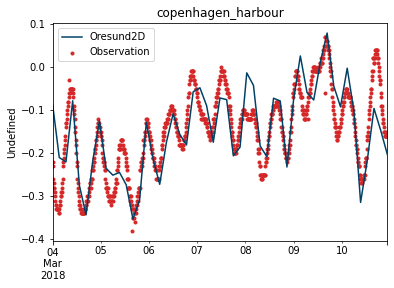

In [27]:
c[0].remove_bias()
c[0].plot_timeseries()

In [28]:
c.skill()

,n,bias,rmse,urmse,mae,cc,si,r2
observation,,,,,,,,
copenhagen_harbour,1001,2.262592e-17,0.053427,0.053427,0.04095,0.83732,0.304616,0.686999
